In [28]:
!pip install yfinance ta scikit-learn matplotlib pandas numpy

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import ta

In [30]:
ticker = "ANTM.JK"
df_downloaded = yf.download(ticker, start="2022-01-01", progress=False)

# Flatten MultiIndex columns and select only the 'Close' price
# This converts columns like ('Price', 'Close') to 'Close'
# and ensures all columns are single-level.
if isinstance(df_downloaded.columns, pd.MultiIndex):
    # Drop the top level of the MultiIndex columns if it's not needed (e.g., 'Price', 'Volume')
    # If the second level names are unique and descriptive (e.g., 'Close', 'Open', 'High')
    df_downloaded.columns = [col[-1] if isinstance(col, tuple) else col for col in df_downloaded.columns]
    # Remove any empty string column names that might result from ticker level
    df_downloaded = df_downloaded.loc[:, df_downloaded.columns != '']

# Now, df_downloaded has single-level columns like 'Close', 'Open', 'High', etc.
# We are interested only in the 'Close' column for our DataFrame
df = df_downloaded[['Close']]
df.head()

/tmp/ipython-input-2067504790.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2022-01-01", progress=False)


Price,Close
Ticker,ANTM.JK
Date,
2022-01-03,1944.578369
2022-01-04,1911.337891
2022-01-05,1886.407349
2022-01-06,1853.166748
2022-01-07,1853.166748


In [32]:
# Ensure Close is 1D
close = df['Close'].squeeze()

df['Return'] = close.pct_change()

df['SMA_5'] = close.rolling(5).mean()
df['SMA_10'] = close.rolling(10).mean()

df['Volatility'] = df['Return'].rolling(10).std()

df['RSI'] = ta.momentum.RSIIndicator(close, window=14).rsi()

df.dropna(inplace=True)
df.head()

Price,Close,Return,SMA_5,SMA_10,Volatility,RSI
Ticker,ANTM.JK,,,,,
Date,,,,,,
2022-01-20,1608.016846,0.121739,1536.549438,1635.024878,0.055084,34.732031
2022-01-21,1616.327026,0.005168,1535.718433,1611.340906,0.055241,35.773301
2022-01-24,1566.466064,-0.030848,1540.704541,1583.501868,0.055458,32.430211
2022-01-25,1462.588989,-0.066313,1537.380469,1556.909338,0.055780,26.809177
2022-01-26,1499.984741,0.025568,1550.676733,1546.106128,0.053529,31.417740


In [33]:
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

In [34]:
X = df[['SMA_5', 'SMA_10', 'Volatility', 'RSI']]
y = df['Target']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [36]:
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [37]:
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 926.9998381292842


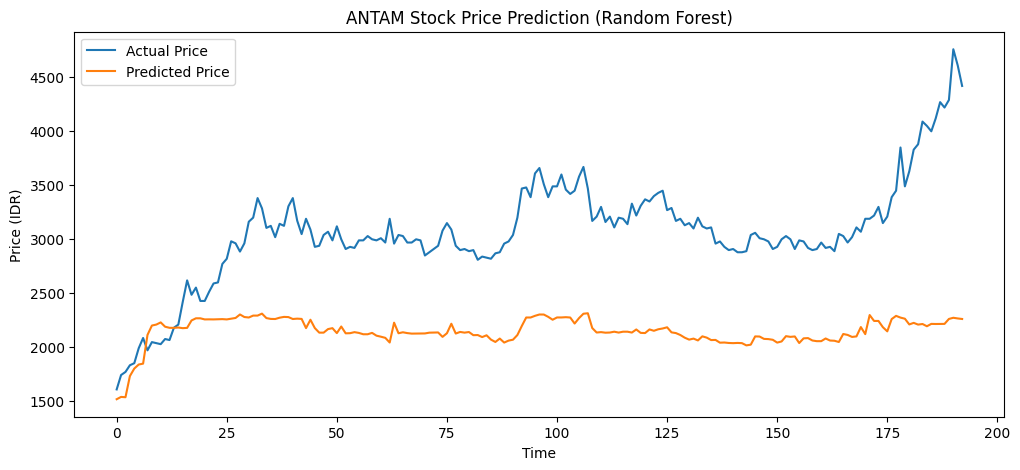

In [38]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.legend()
plt.title("ANTAM Stock Price Prediction (Random Forest)")
plt.xlabel("Time")
plt.ylabel("Price (IDR)")
plt.show()

In [45]:
!pip install xgboost

In [46]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [47]:
xgb_predictions = xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print("Random Forest MAE:", mae)
print("XGBoost MAE:", xgb_mae)

Random Forest MAE: 926.9998381292842
XGBoost MAE: 943.9000370638358


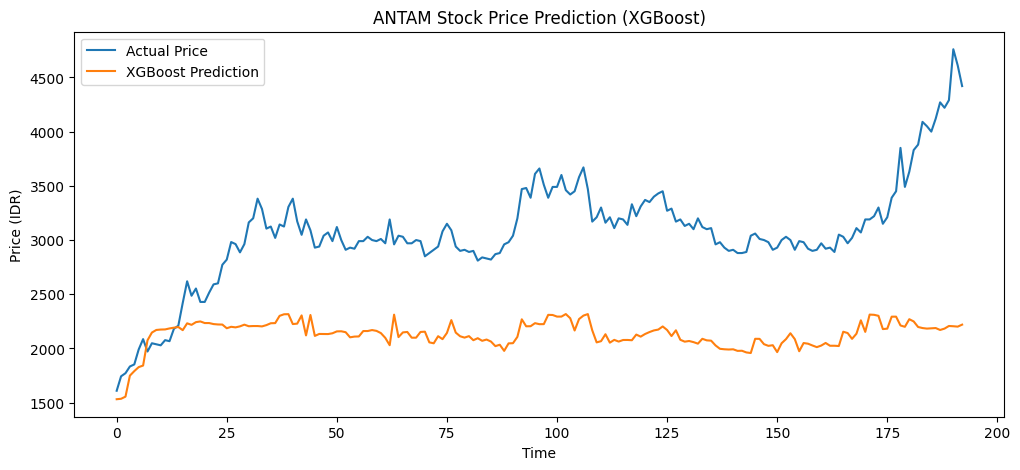

In [49]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual Price")
plt.plot(xgb_predictions, label="XGBoost Prediction")
plt.legend()
plt.title("ANTAM Stock Price Prediction (XGBoost)")
plt.xlabel("Time")
plt.ylabel("Price (IDR)")
plt.show()

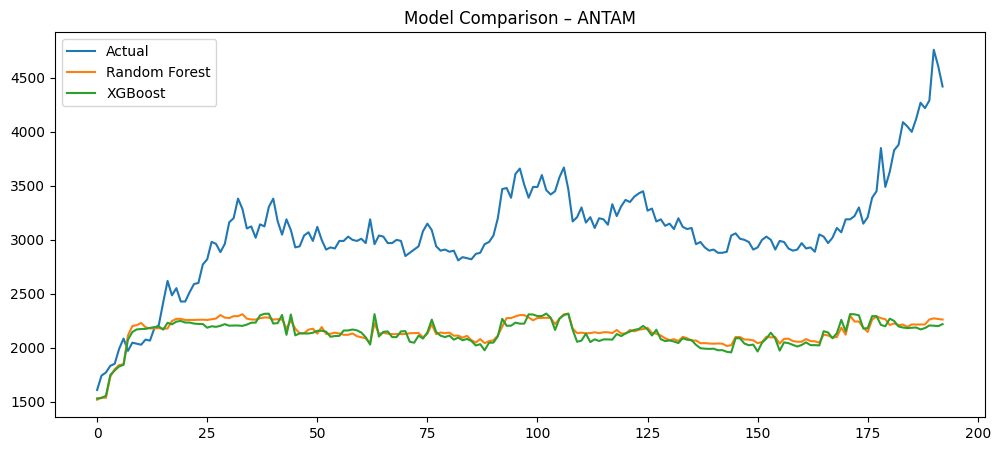

In [48]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Random Forest')
plt.plot(xgb_predictions, label='XGBoost')
plt.legend()
plt.title("Model Comparison – ANTAM")
plt.show()